In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import seaborn as sn
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib.path import Path
from sklearn.metrics import classification_report, confusion_matrix

from keras.optimizers import Adam


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Data loading and preprocessing

In [2]:
from src.arrange_dataset import arrange_dataset

data_dir = arrange_dataset()     

Dataset arranged in ./data


In [3]:
from src.data_loader3D import NiiSequence, dataGenerator
from sklearn.model_selection import train_test_split

nb_classes = 2

train_set, train_labels = dataGenerator(data_dir, mode="train", nb_classes=nb_classes)
test_set, test_labels = dataGenerator(data_dir, mode="val", nb_classes=nb_classes)
train_set, val_set, train_labels, val_labels = train_test_split(train_set, train_labels, test_size=0.2, random_state=42)

print("Train set size: ", len(train_set))
print("Validation set size: ", len(val_set))
print("Test set size: ", len(test_set))

batch_size = 16

train_sequence = NiiSequence(train_set, batch_size, nb_classes=nb_classes, mode="HC")
val_sequence = NiiSequence(val_set, batch_size, nb_classes=nb_classes, mode="HC")
test_sequence = NiiSequence(test_set, batch_size, nb_classes=nb_classes, mode="HC",shuffle=False)

print("Shape of one MRI element:", train_sequence[0][0].shape)
print("Train label example after loading:", train_sequence[0][1])

print("Shape of one batch:", test_sequence[0][0].shape)
print("Test label example after loading:", test_sequence[0][1])

Train set size:  266
Validation set size:  67
Test set size:  85
Shape of one MRI element: (16, 40, 40, 80, 1)
Train label example after loading: [[0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Shape of one batch: (16, 40, 40, 80, 1)
Test label example after loading: [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


Scan Visualization

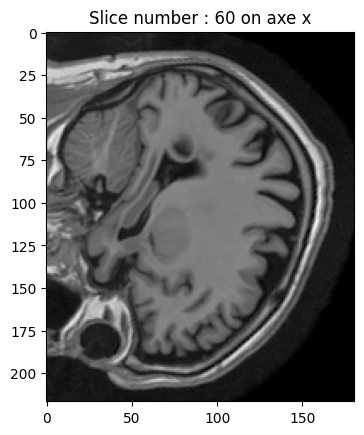

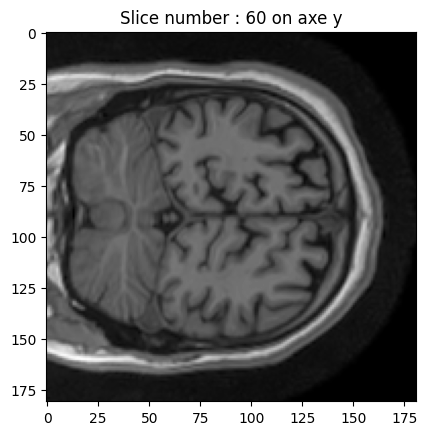

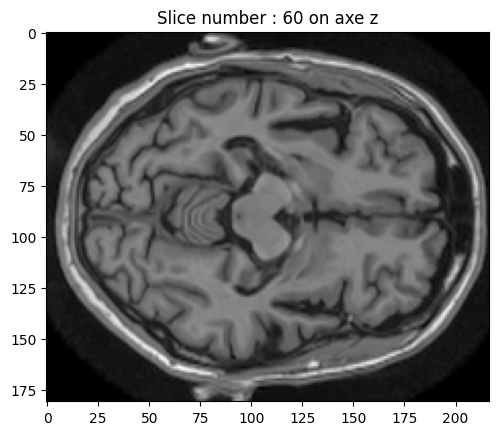

In [4]:
# MRI images are composed by many slices, build a montage of the them
def show_2D(irm, slice, axe):
    if axe == "x":
        plt.imshow(irm[slice,:,:], cmap="gray")
    elif axe == "y":
        plt.imshow(irm[:,slice,:], cmap="gray")
    elif axe == "z":
        plt.imshow(irm[:,:,slice], cmap="gray")
    plt.title("Slice number : " + str(slice) + " on axe " + axe)
    plt.show()
    
img = nib.load(train_set[0])
show_2D(img.get_fdata(), 60, "x")
show_2D(img.get_fdata(), 60, "y")
show_2D(img.get_fdata(), 60, "z")

Imbalanced Data

{'CN': 227, 'AD': 191}


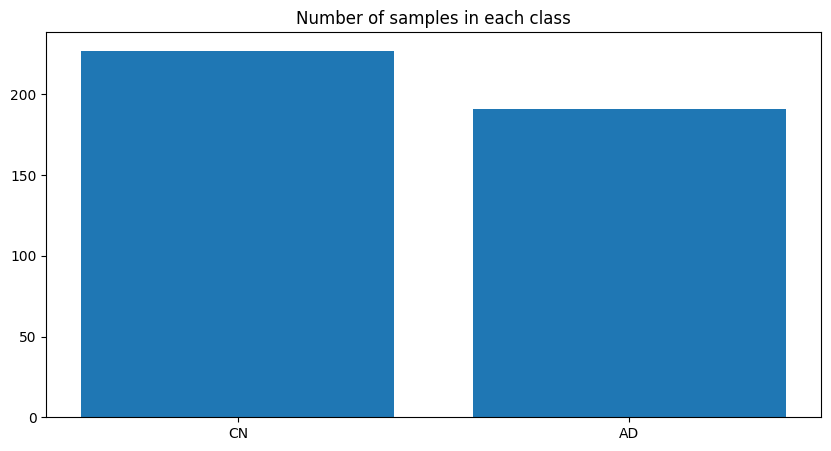

In [5]:
## Calculate number of samples in each class.
input_folder = 'lib'
class_counts = dict()
class_names = ["CN", "SMCI", "PMCI", "AD"]
if nb_classes == 2:
    class_names = ["CN", "AD"]
for folder in class_names:
    class_counts[folder] = len(os.listdir(input_folder+'/'+folder))

print(class_counts)

# plot the number of samples in each class
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Number of samples in each class')
plt.show()

3D Convolutional Neural Network

In [6]:
from src.bi_classifier3D import Biclassifier3D

input_shape = (train_sequence[0][0].shape[1], train_sequence[0][0].shape[2], train_sequence[0][0].shape[3], train_sequence[0][0].shape[4])
print("Input shape:", input_shape)
bicl = Biclassifier3D(input_shape, n_classes=nb_classes, n_filters=8, kernel_size=3, activation='relu', dropout=0.2)
model = bicl.build_model()
model.summary()
# Compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=2e-3),
    metrics=['accuracy'],
)

Input shape: (40, 40, 80, 1)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 40, 80, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 40, 40, 80, 8)     224       
                                                                 
 batch_normalization (Batch  (None, 40, 40, 80, 8)     32        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 40, 40, 80, 8)     0         
                                                                 
 conv3d_1 (Conv3D)           (None, 40, 40, 80, 8)     1736      
                                                                 
 activation_1 (Activation)   (None, 40, 40, 80, 8)     0         
                                

/home/ybelkhedra/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model training

In [7]:
# checkpoint
filepath="classifier3D_AD_CN_F2-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1)

callbacks_list = [checkpoint, early_stop, reduce_lr]

In [8]:
model.fit(
    train_sequence,
    validation_data=val_sequence,
    validation_steps=len(val_set) // batch_size,
    callbacks=callbacks_list,
    epochs=5,
)

Epoch 1/5
17/17 [==============================] - ETA: 0s - loss: 0.4688 - accuracy: 0.7782
Epoch 1: val_accuracy improved from -inf to 0.78125, saving model to classifier3D_AD_CN_F2-01-0.78.hdf5
17/17 [==============================] - 47s 2s/step - loss: 0.4688 - accuracy: 0.7782 - val_loss: 0.5848 - val_accuracy: 0.7812 - lr: 0.0020
Epoch 2/5


/home/ybelkhedra/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - ETA: 0s - loss: 0.1477 - accuracy: 0.9549
Epoch 2: val_accuracy improved from 0.78125 to 0.82812, saving model to classifier3D_AD_CN_F2-02-0.83.hdf5
17/17 [==============================] - 43s 3s/step - loss: 0.1477 - accuracy: 0.9549 - val_loss: 0.7018 - val_accuracy: 0.8281 - lr: 0.0020
Epoch 3/5
17/17 [==============================] - ETA: 0s - loss: 0.0347 - accuracy: 0.9887
Epoch 3: val_accuracy did not improve from 0.82812
17/17 [==============================] - 44s 3s/step - loss: 0.0347 - accuracy: 0.9887 - val_loss: 0.8485 - val_accuracy: 0.7969 - lr: 0.0020
Epoch 4/5
17/17 [==============================] - ETA: 0s - loss: 0.0076 - accuracy: 1.0000
Epoch 4: val_accuracy did not improve from 0.82812
17/17 [==============================] - 46s 3s/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.9644 - val_accuracy: 0.7812 - lr: 0.0020
Epoch 5/5
17/17 [==============================] - ETA: 0s - loss: 0.0028 - accuracy: 1.0000
Epo

In [9]:
# model.fit(
#     train_sequence,
#     validation_data=val_sequence,
#     validation_steps=len(val_set) // batch_size,
#     callbacks=callbacks_list,
#     epochs=20,
# )

Visualizing Training History

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


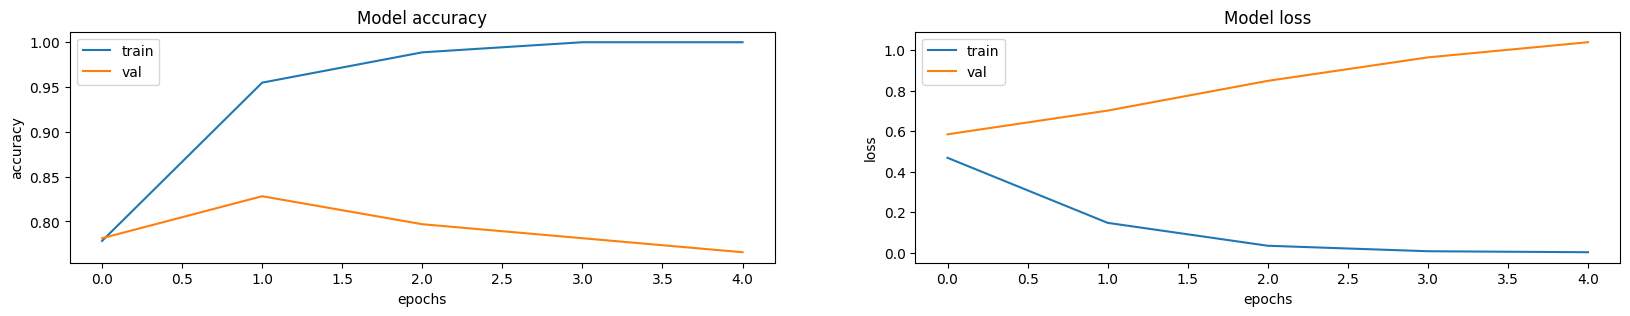

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

print(model.history.history.keys())
for i, metric in enumerate(['accuracy', 'loss']):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history[f'val_{metric}'])
    ax[i].set_title(f'Model {metric}')
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(metric)
    ax[i].legend(['train', 'val'])

Model Evaluation

In [7]:
#model.load_weights("./classifier3D_AD_CN_F2-02-0.83.hdf5", skip_mismatch=False)
model.evaluate(test_sequence, verbose=1)

6/6 [==============================] - 12s 2s/step - loss: 0.4867 - accuracy: 0.8235


[0.48674649000167847, 0.8235294222831726]

In [8]:
y = model.predict(test_sequence)
y_pred = y.argmax(axis=1)
y_test = np.array(test_labels)
print(y_pred.shape)
print(y_test.shape)
print(np.sum(y_pred == y_test)/len(y_pred))

6/6 [==============================] - 12s 2s/step
(85,)
(85,)
0.8235294117647058


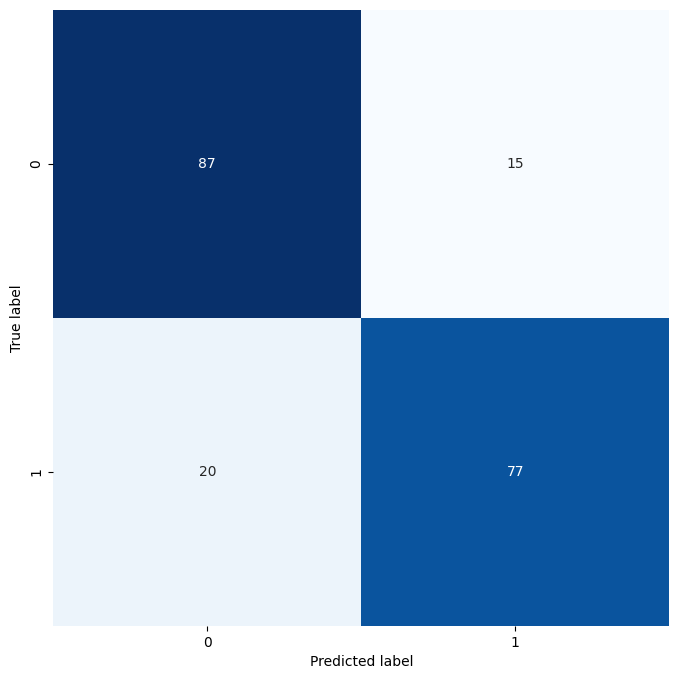

In [9]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm_ = cm / cm.astype(float).sum(axis=1) * 100
plt.figure(figsize=(8, 8))
sn.heatmap(cm_, annot=True, square=True, cmap='Blues', cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

Test du modèle sur les données PMCI et SMCI

In [10]:
set_SP, labels_SP = dataGenerator(data_dir, mode="train", nb_classes=4)
print(len(set_SP), len(labels_SP))
new_set, new_labels = [], []
for p,l in zip(set_SP, labels_SP):
    if l == 1:
        new_set.append(p)
        new_labels.append(0)
    elif l == 2:
        new_set.append(p)
        new_labels.append(1)

print(len(new_set))

from src.data_loader3D import NiiSequence2

sp_sequence = NiiSequence2(new_set, new_labels, batch_size, nb_classes=2, mode="HC", shuffle=False)
print("Shape of one MRI element:", sp_sequence[0][0].shape)
print("Train label example after loading:", sp_sequence[0][1])

print("Shape of one batch:", sp_sequence[0][0].shape)
print("Test label example after loading:", sp_sequence[0][1])

572 572
239
Shape of one MRI element: (16, 40, 40, 80, 1)
Train label example after loading: [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
Shape of one batch: (16, 40, 40, 80, 1)
Test label example after loading: [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [14]:
y_ = model.predict(sp_sequence)

15/15 [==============================] - 32s 2s/step
(239,)
(572,)


ValueError: operands could not be broadcast together with shapes (239,) (572,) 

In [15]:
y__pred = y_.argmax(axis=1)
y__test = np.array(new_labels)
print(y__pred.shape)
print(y__test.shape)
print(np.sum(y__pred == y__test)/len(y__pred))

(239,)
(239,)
0.6276150627615062


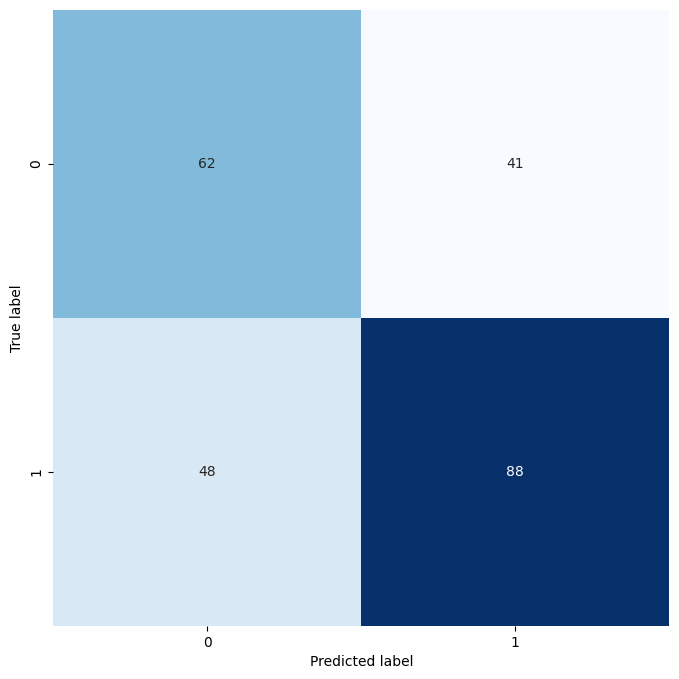

In [17]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y__test, y__pred)
cm_ = cm / cm.astype(float).sum(axis=1) * 100
plt.figure(figsize=(8, 8))
sn.heatmap(cm, annot=True, square=True, cmap='Blues', cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()